In [1]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras 
from tensorflow.keras import models, layers

from pprint import pprint
from datetime import datetime
import collections
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# %tensorflow_version 1.x
import tensorflow as tf

tf.__version__

'2.6.0'

In [6]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Mon Nov  8 10:26:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    69W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# !unzip /content/drive/MyDrive/Colab Notebooks/datasets/mbsa.csv.zip

unzip:  cannot find or open /content/drive/MyDrive/Colab, /content/drive/MyDrive/Colab.zip or /content/drive/MyDrive/Colab.ZIP.


In [13]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/mbsa.csv.zip'

-rw------- 1 root root 1182141602 Nov  8 06:05 '/content/drive/MyDrive/Colab Notebooks/datasets/mbsa.csv.zip'


In [15]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/datasets/mbsa.csv.zip')
zip_file.extractall()

In [16]:
!ls -l

total 3053812
drwx------ 5 root root       4096 Nov  8 10:24 drive
-rw-r--r-- 1 root root 3127087532 Nov  8 10:34 mbsa.csv
drwxr-xr-x 1 root root       4096 Nov  1 13:35 sample_data


In [17]:
mbsa = pd.read_csv('mbsa.csv')
mbsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19344048 entries, 0 to 19344047
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Date       object
 1   text       object
 2   Sentiment  object
dtypes: object(3)
memory usage: 442.8+ MB


In [18]:
mbsa = mbsa[mbsa['Sentiment'].notnull()]
mbsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18452904 entries, 0 to 19344047
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Date       object
 1   text       object
 2   Sentiment  object
dtypes: object(3)
memory usage: 563.1+ MB


In [19]:
mbsa['Sentiment'].value_counts()

Negative    9729297
Positive    8723207
Neutral         400
Name: Sentiment, dtype: int64

In [20]:
neg = mbsa[mbsa['Sentiment'] == 'Negative'][:10000]
pos = mbsa[mbsa['Sentiment'] == 'Positive'][:10000]
neu = mbsa[mbsa['Sentiment'] == 'Neutral']

In [21]:
neg

,Date,text,Sentiment
77949,2019-05-21,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",Negative
77950,2019-05-21,IDAX #Japan #エアドロップ\n\n海外取引所 #IDAX 日本語アカウントのオー...,Negative
77951,2019-05-21,Multiply your Bitcoin and Ethereum: https://t...,Negative
77952,2019-05-21,Game of DOGEs begun! Become a champion of the ...,Negative
77953,2019-05-21,"$BTC levels \n\nSupport: 7600, 7200, 6800, 640...",Negative
...,...,...,...
87944,2019-05-21,@gainbtsmuttuals Join me on https://t.co/UkDeH...,Negative
87945,2019-05-21,Interested in winning big ?? Call or text 0902...,Negative
87946,2019-05-21,And the price doesn't care. Bitcoin is still c...,Negative
87947,2019-05-21,My appetite for Risks is very high \nI would l...,Negative


In [22]:
result = pd.concat([neg, pos, neu])
result

,Date,text,Sentiment
77949,2019-05-21,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",Negative
77950,2019-05-21,IDAX #Japan #エアドロップ\n\n海外取引所 #IDAX 日本語アカウントのオー...,Negative
77951,2019-05-21,Multiply your Bitcoin and Ethereum: https://t...,Negative
77952,2019-05-21,Game of DOGEs begun! Become a champion of the ...,Negative
77953,2019-05-21,"$BTC levels \n\nSupport: 7600, 7200, 6800, 640...",Negative
...,...,...,...
5399594,2017-02-28,$1199.87 at 01:15 UTC [24h Range: $1169.00 - $...,Neutral
5399595,2017-02-28,$1206.00 #bitfinex;\n$1206.20 #GDAX;\n$1185.00...,Neutral
5399596,2017-02-28,1 #BTC (#Bitcoin) quotes:\n$1199.83/$1199.89 #...,Neutral
5399597,2017-02-28,One Bitcoin now worth $1199.88@bitstamp. High ...,Neutral


In [23]:
result['Sentiment'].value_counts()

Positive    10000
Negative    10000
Neutral       400
Name: Sentiment, dtype: int64

In [24]:
ticker_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)')
ht_pattern = re.compile(r'#\w+')

ticker_dic = collections.defaultdict(int)
ht_dic = collections.defaultdict(int)

for text in result['text']:
    for word in text.split():
        if ticker_pattern.fullmatch(word) is not None:
            ticker_dic[word[1:]] += 1

            word = word.lower()
            if ht_pattern.fullmatch(word) is not None:
                ht_dic[word] += 1

In [28]:
charonly = re.compile(r'[^a-zA-Z\s]')
handle_pattern = re.compile(r'@\w+')
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
url_pattern = re.compile(
    'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pic_pattern = re.compile('pic\.twitter\.com/.{10}')
special_code = re.compile(r'(&amp;|&gt;|&lt;)')
tag_pattern = re.compile(r'<.*?>')

STOPWORDS = set(stopwords.words('english')).union({'rt', 'retweet', 'RT', 'Retweet', 'RETWEET'})

lemmatizer = WordNetLemmatizer()

def hashtag(phrase):
    return ht_pattern.sub(' ', phrase)

def remove_ticker(phrase):
    return ticker_pattern.sub('', phrase)
    
def specialcode(phrase):
    return special_code.sub(' ', phrase)

def emoji(phrase):
    return emoji_pattern.sub(' ', phrase)

def url(phrase):
    return url_pattern.sub('', phrase)

def pic(phrase):
    return pic_pattern.sub('', phrase)

def html_tag(phrase):
    return tag_pattern.sub(' ', phrase)

def handle(phrase):
    return handle_pattern.sub('', phrase)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # DIS, ticker symbol of Disney, is interpreted as the plural of "DI" 
    # in WordCloud, so I converted it to Disney
    phrase = re.sub('DIS', 'Disney', phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"(he|He)\'s", "he is", phrase)
    phrase = re.sub(r"(she|She)\'s", "she is", phrase)
    phrase = re.sub(r"(it|It)\'s", "it is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"(\'ve|has)", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def onlychar(phrase):
    return charonly.sub('', phrase)

def remove_stopwords(phrase):
    return " ".join([word for word in str(phrase).split()\
                     if word not in STOPWORDS])

def tokenize_stem(phrase):   
    tokens = word_tokenize(phrase)
    stem_words =[]
    for token in tokens:
        word = lemmatizer.lemmatize(token)
        stem_words.append(word)        
    buf = ' '.join(stem_words)    
    return buf

In [29]:
def arrange_text(ds):
    ds['text2'] = ds['text'].apply(emoji)
    ds['text2'] = ds['text2'].apply(handle)
    ds['text2'] = ds['text2'].apply(specialcode)
    ds['text2'] = ds['text2'].apply(hashtag)
    ds['text2'] = ds['text2'].apply(url)
    ds['text2'] = ds['text2'].apply(pic)
    ds['text2'] = ds['text2'].apply(html_tag)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(decontracted)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(tokenize_stem)
    ds['text2'] = ds['text2'].apply(remove_stopwords)

In [36]:
# !pip install tqdm
# from tqdm import trange, notebook
# for page in notebook.tqdm(range(100000)):
arrange_text(result)
result.head(20)

,Date,text,Sentiment,text2
77949,2019-05-21,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",Negative,BTC IS STILL GOING STRONG Thus giving away BTC...
77950,2019-05-21,IDAX #Japan #エアドロップ\n\n海外取引所 #IDAX 日本語アカウントのオー...,Negative,IDAX BTC Idax
77951,2019-05-21,Multiply your Bitcoin and Ethereum: https://t...,Negative,Multiply Bitcoin Ethereum
77952,2019-05-21,Game of DOGEs begun! Become a champion of the ...,Negative,Game DOGEs begun Become champion Lord Duck get...
77953,2019-05-21,"$BTC levels \n\nSupport: 7600, 7200, 6800, 640...",Negative,BTC level Support Resistance moon
77954,2019-05-21,Unofficial annual inflation in Argentina is es...,Negative,Unofficial annual inflation Argentina estimate...
77955,2019-05-21,Join Dogemarkets and start claiming DOGE BTC L...,Negative,Join Dogemarkets start claiming DOGE BTC LTC G...
77956,2019-05-21,This is the future of the dollar.\nThis is the...,Negative,This future dollar This future every fiat curr...
77957,2019-05-21,Moon trip #BTC #Trx #Xrp #Xlm,Negative,Moon trip
77958,2019-05-21,@WajeCleaning @joaquinjuarez22,Negative,


In [37]:
result.tail(20)

,Date,text,Sentiment,text2
5399579,2017-02-28,One Bitcoin now worth $1200.00@bitstamp. High ...,Neutral,One Bitcoin worth High Low Market Cap Billion
5399580,2017-02-28,$1200.00 at 02:30 UTC [24h Range: $1169.00 - $...,Neutral,UTC h Range Volume BTC
5399581,2017-02-28,@CherylABC7 http://www.coindesk.com/price/ Bi...,Neutral,Bitcoin month summary Ahead March SEC ruling B...
5399582,2017-02-28,http://www.coindesk.com/price/ Bitcoin 3 mont...,Neutral,Bitcoin month summary Ahead March SEC ruling B...
5399583,2017-02-28,$1199.80 at 02:15 UTC [24h Range: $1169.00 - $...,Neutral,UTC h Range Volume BTC
5399584,2017-02-28,☆OnePunchLTD運用8日目配当 6.00％回収率 36.00％https://one...,Neutral,OnePunchLTD
5399585,2017-02-28,☆X-Binary運用17日目配当 2.00％回収率 24.04％https://x-bin...,Neutral,XBinary
5399586,2017-02-28,$1206.20 #bitfinex;\n$1208.95 #GDAX;\n$1184.50...,Neutral,news
5399587,2017-02-28,☆BitRegion運用119日目配当 1.00％回収率 168.86%https://bi...,Neutral,BitRegion
5399588,2017-02-28,One Bitcoin now worth $1199.90@bitstamp. High ...,Neutral,One Bitcoin worth High Low Market Cap Billion


In [38]:
result = result[result['Sentiment'].notnull()]
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20400 entries, 77949 to 5399598
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       20400 non-null  object
 1   text       20400 non-null  object
 2   Sentiment  20400 non-null  object
 3   text2      20400 non-null  object
dtypes: object(4)
memory usage: 796.9+ KB


In [39]:
result = result.replace({'Sentiment': 'Positive'}, {'Sentiment': 0})
result = result.replace({'Sentiment': 'Neutral'}, {'Sentiment': 1})
result = result.replace({'Sentiment': 'Negative'}, {'Sentiment': 2})

result.head()

,Date,text,Sentiment,text2
77949,2019-05-21,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",2,BTC IS STILL GOING STRONG Thus giving away BTC...
77950,2019-05-21,IDAX #Japan #エアドロップ\n\n海外取引所 #IDAX 日本語アカウントのオー...,2,IDAX BTC Idax
77951,2019-05-21,Multiply your Bitcoin and Ethereum: https://t...,2,Multiply Bitcoin Ethereum
77952,2019-05-21,Game of DOGEs begun! Become a champion of the ...,2,Game DOGEs begun Become champion Lord Duck get...
77953,2019-05-21,"$BTC levels \n\nSupport: 7600, 7200, 6800, 640...",2,BTC level Support Resistance moon


In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(result['text2'], result['Sentiment'],
                                                    test_size = 0.2,
                                                    random_state = 777,
                                                    stratify = result['Sentiment'])

In [47]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16320,), (16320,), (4080,), (4080,))

In [48]:
y_test.value_counts()

2    2000
0    2000
1      80
Name: Sentiment, dtype: int64

In [49]:
sentences = [sentence.split(' ') for sentence in x_train]

In [50]:
sentences

[['BTC', 'Flyer'],
 ['yln', 'en', 'yksek', 'seviyesinde', 'srada', 'dolar', 'var'],
 ['BaknzAz',
  'nce',
  'bi',
  'sefili',
  'daha',
  'BLOCKLADIM',
  'Szde',
  'BELENSAY',
  'Dostu',
  'YTD'],
 ['The',
  'Bitcoin',
  'BTC',
  'price',
  'currently',
  'USD',
  'EUR',
  'Its',
  'number',
  'cryptocurrency',
  'Earth',
  'market',
  'capitalization',
  'million',
  'USD',
  'Last',
  'change',
  'h',
  'h'],
 ['I', 'red', 'btc', 'sir', 'We', 'together', 'lmao'],
 ['PrimeXBT',
  'BTC',
  'KNC',
  'GNT',
  'AION',
  'PAY',
  'TRX',
  'ZEC',
  'NXT',
  'NXT',
  'CRO',
  'DGB'],
 ['L', 'BTC', 'S'],
 ['Twitter'],
 ['BTC', 'ETH', 'XRP', 'BCH', 'EOS', 'EOS'],
 ['LTCUsD',
  'sideways',
  'doe',
  'look',
  'weak',
  'LTC',
  'since',
  'call',
  'day',
  'ago',
  'I',
  'play',
  'LTCBTC',
  'right'],
 ['Crypto',
  'News',
  'FCA',
  'Currency',
  'Crypto',
  'Scams',
  'Hit',
  'BitMEXs',
  'Insurance',
  'Fund',
  'Now',
  'Has',
  'Over',
  'Million',
  'Bitcoin',
  'SEC',
  'delayed',
 

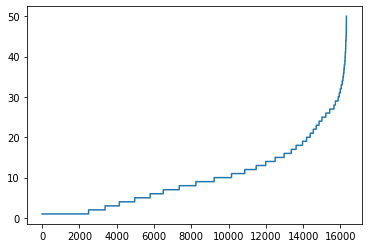

In [51]:
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

# print(sum([int(i <= 25) for i in sentence_len]))

In [52]:
max(sentence_len)

50

In [91]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 1000000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)

train_X = pad_sequences(train_X, padding = 'post')

print(train_X[:5])

[[   1 8067    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [3754   44 2612 3755 4449  950 1702    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [8068 4450 2227 8069 1138 8070 8071 1827 8072  597    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  10    2    1    4  292    3  278   95  316   62 2069   14 2228  355
     3   49   60   29   29    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

In [92]:
train_X.shape

(16320, 50)

In [93]:
print(tokenizer.index_word[17500])
print(tokenizer.index_word[3000])

temp = tokenizer.texts_to_sequences(['yln', 'en', 'yksek', 'seviyesinde', 'srada'])
print(temp)

temp = pad_sequences(temp, padding = 'post')
print(temp)

laughable
commercial
[[3754], [44], [2612], [3755], [4449]]
[[3754]
 [  44]
 [2612]
 [3755]
 [4449]]


In [69]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Embedding(100000, 300, input_length = 50))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.LSTM(128))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'mean_squared_error',
              optimizer = adam(0.001),
              metrics = ['accuracy'])

model.summary()

NameError: ignored

In [94]:
def model_fn():

    LR = Choice('learning_rate', [0.001, 0.0005, 0.0001], group='optimizer')
    DROPOUT_RATE = Linear('dropout_rate', 0.0, 0.5, 5, group='dense')
    NUM_DIMS = Range('num_dims', 8, 32, 8, group='dense')
    NUM_LAYERS = Range('num_layers', 1, 3, group='dense')
    L2_NUM_FILTERS = Range('l2_num_filters', 8, 64, 8, group='cnn')
    L1_NUM_FILTERS = Range('l1_num_filters', 8, 64, 8, group='cnn')

    model = Sequential()
    model.add(Conv2D(L1_NUM_FILTERS, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(L2_NUM_FILTERS, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    for _ in range(NUM_LAYERS):
        model.add(Dense(NUM_DIMS, activation='relu'))
        model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(1, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(LR))

    return model

In [71]:
tuner = Tuner(model_fn, 'val_accuracy', epoch_budget=500, max_epochs=5)
tuner.search(train_X, y_train, validation_split = 0.2)

NameError: ignored

In [116]:
from tensorflow.keras.preprocessing import sequence

max_features = 20000
max_len = 50

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(128, 2, activation = 'relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 2, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(64, 2, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 2, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=Adam(lr=5e-3),
             loss='mean_squared_error',
             metrics=['acc'])
history = model.fit(train_X, y_train,
                   epochs = 100,
                   batch_size=128,
                   validation_split=0.2)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 50, 128)           2560000   
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 49, 128)           32896     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 24, 128)           0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 23, 64)            16448     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 6, 64)             8256      
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 2, 64)           

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100).to_list(),
    'learning_rate': reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data = )

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import SGD

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
keras_reg = tensorflow.keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

keras_reg.fit(train_X, y_train, epochs=100,
             validation_split = 0.2)

Epoch 1/100


ValueError: in user code:

    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:820 train_function  *
        return step_function(self, iterator)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:810 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:803 run_step  **
        outputs = model.train_step(data)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:753 train_step
        y_pred = self(x, training=True, step_not_overridden=True)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:990 __call__
        self.name)
    /home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_14 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape [32, 50]


In [ ]:
history = model.fit(train_X, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

In [ ]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [ ]:
sentences = [sentence.split(' ') for sentence in x_test]

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding = 'post')

model.evaluate(test_X, y_test, verbose = 0)